# Facebook-Data-Preprocessing&EDA
by Allen Huang

In [60]:
import re
import string
import nltk
import random
import pandas as pd
import numpy as np
import networkx as nx
import plotly.express as px
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from gensim.models import word2vec
from textblob import TextBlob
from sklearn.manifold import TSNE
from datetime import datetime
from textblob.sentiments import NaiveBayesAnalyzer
from tqdm._tqdm_notebook import tqdm_notebook
from pandarallel import pandarallel
from sklearn.feature_extraction.text import (
    CountVectorizer, 
    TfidfTransformer, 
    TfidfVectorizer,)
from wordcloud import WordCloud, ImageColorGenerator,STOPWORDS

pandarallel.initialize(progress_bar=True,nb_workers=3)
tqdm_notebook.pandas()
pd.options.mode.chained_assignment = None
pd.set_option('max_colwidth',500)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

for resource in 'stopwords', 'punkt', 'wordnet','movie_reviews':
    nltk.download(resource)

INFO: Pandarallel will run on 3 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


/Users/hkmac/anaconda3/lib/python3.7/site-packages/tqdm/std.py:668: FutureWarning:

The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version

[nltk_data] Downloading package stopwords to /Users/hkmac/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/hkmac/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/hkmac/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package movie_reviews to
[nltk_data]     /Users/hkmac/nltk_data...
[nltk_data]   Package movie_reviews is already up-to-date!


## Load data

In [61]:
def open_file(PATH):
    with open(PATH, "r") as r:
        # read and remove unicode
        content = re.sub(r'\\\w[0|2]0\w{2}\w?', '', r.read()).replace(",","").replace('"','')
        content = re.sub(r'\\u[d|0|2|f|3|c|b]\w{3}', '', content).split("\\n")
        # # remove empty string
        while '' in content:
            content.remove("")
    
    return content
            
content = open_file("original_dataset/Facebook_USPS_Content.json")

In [62]:
del content[:2]

*Some underlying rules in our data:*

###### Example
'You can update your address on your phone tablet or computer! Submit your change of address from home in minutes at https://moversguide.usps.com/mgo/disclaimer **Kelly Curry-Sugarman**'

'Why do you lose so many packages this time of year? 3 years in a row not COVID related.. I spent a week of vacation on the phone first week in July the year before last and I had packages missing last June too. I a power seller on EBAY this doesn happen at Christmas Why June and July? Why do you not train people that fill in for vacations to scan packages? It the 25th I have yet ANOTHER lost package and angry customer!!!! Package has not been scanned since June 14th!! Why? UPDATE: Since I POSTED This ANOTHER PACKAGE NOT MOVING FOR 5 days...'

###### Example
'James Jacobs replied  1 reply  **Blane Harry**',
 "Why doesn't my mail man pick up my mail. He hasn't picked my mail for 4 days. And they are Important bills that have to be paid. Lakeview Apartments Galeville New York. Just outside of the town is Liverpool New York.",
 '2  Like  React  Reply  More  Jun 25 at 6:50 PM'
 
###### Example
"4  Like  React  Reply  More  Jun 26 at 7:34 AM **La'Keisha D Watson**",
 "I haven't received my mail in a week and the local office keeps giving me the runaround. I sent emails with no result. I am disabled and it's hard for me to get to the local office. How can this be resolved??????? I also sent a pm to this page",
 '3  Like  React  Reply  More  Jun 25 at 6:28 PM',
 
###### Example
5 replies **Tina Stillions-McAferty**
Thank you postal workers for all you do. Stay safe
12  Like  React  Reply  More  Apr 27

In [63]:
# show a random piece 
random_int = random.randint(0,len(content)-11)
content[random_int:random_int+20]

['Cathy Gampper thank youmy customers take very good care of me!! It greatly appreciated!!',
 '3  Like  React  More  Jun 9 Marleena Ranglar',
 "Paula Gayle Carriers aren't allowed to accept gifts. Not sure what they can receive as appreciation? Maybe Nikki Renfro could give us some ideas?",
 '2  Like  React  More  Jun 10 Nikki Renfro',
 'Marleena Ranglar a gift can be a bottle of frozen water Gatorade snacks etc..I don know if youe meaning it in a hateful way or if youe serious but maybe you can screenshot where it says a carrier can receive ifts in our employee handbook. I deliver in Texas where it a heat index of 110+ so I get quite a few ifts during the day on my very large route!',
 'Edited  3  Like  React  More  Jun 10 Paula Gayle',
 'Nikki Renfro I thought you were one of the complainers I apologize. Ie always appreciated and chat with my postal worker I was serious I have had my kids hand them treats that wee made to thank them. I appreciate the work that people in general do to

## Feature Extraction

In [64]:
text = []
like = []
date = []
reply_to = []
text = []
name = [] 

def is_break_point(astring:str):
    if 'React' in astring:
        return True
    if len(re.findall(r"replied\s+\d+\s+repl\w*",astring)) != 0:
        return True
    if len(re.findall(r"\d*\s+repl\w*",astring)) != 0:
        return True
    else:
        return False
    
def find_like(astring:str):
    like = re.findall(r"\d+\.?\d*",astring[:20])
    if len(like) == 0:
        return 0
    else:
        return like[0]
    
def find_name(astring:str):
    pattern = re.compile(r"[A-Z]\w*\s[A-Z]?['|.]?[A-Z]+\w*")
    matches = pattern.findall(astring)

    if len(matches) == 0:
        return False
    else:
        return matches[0]
    
def find_name_by_time(astring:str):
    name = ""
    # when we have specific time 
    if 'AM' in astring or 'PM' in astring:
        for i in range(len(astring)):
            if astring[i] == 'M' and astring[i-1] in ["A","P"]:
                name = astring[i+1:].strip()
    elif 'ago' in astring:
        for i in range(len(astring)):
            if astring[i:i+3] == 'ago':
                name =  astring[i+4:].strip()

    else:
        pattern = re.compile(r"\w{3} \d+")
        matches = pattern.findall(astring)
        index = astring.index(matches[0])
        name = astring[index+len(matches[0]):].strip()
            
    if len(name) > 50:
        name = find_name_by_view_post(name)
    return name
                
                
def find_name_by_view_post(astring:str):
    for i in range(len(astring)):
        if astring[i:i+9] == 'View post':
            return astring[i+10:].strip()
    
        
def find_name_by_replies(astring:str):
    name = ""
    for i in range(len(astring)):
        if 'View post' in astring:
            return find_name_by_view_post(astring)
        if astring[i:i+5] == 'reply':
            name = astring[i+6:].strip()
        if astring[i:i+7] == 'replies':
            name = astring[i+8:].strip()
    if len(name) > 0:
        return name
    else:
        return find_name(astring)
        
def find_date(astring:str):
    pattern = re.compile(r"\w{3} \d+")
    matches = pattern.findall(astring)
    
    if len(matches) == 0:
        return None
    else:
        return matches[0]
# the first name is in the post description
name.append('Kelly Curry-Sugarman')

for i in range(len(content)):
    # reach the break point
    if 'React' in content[i]:
        date.append(find_date(content[i]))
        like.append(find_like(content[i]))
        
        current = i-1
        long_text = ""
        # combine one's comments at the same time
        while not is_break_point(content[current]):
            long_text += content[current] + ' '
            current -= 1
        text.append(long_text)
        
        # extract reply_to information
        if find_name(long_text[:40]):
            if long_text.split(" ")[1] == 'I':
                reply_to.append("")
            else:
                reply_to.append(find_name(long_text[:40]))
        else:
            reply_to.append("")
        
        if 'React' in content[current]:
            try:
                name.append(find_name_by_time(content[current]))
            except Exception:
                name.append("")
                
        if len(re.findall(r"replied\s+\d+\s+repl\w*",content[current])) != 0:
            name.append(find_name_by_replies(content[current]))
        
        elif len(re.findall(r"\d*\s+repl\w*",content[current])) != 0:
            name.append(find_name_by_replies(content[current]))
            

del name[1]

df = pd.DataFrame({"name":name,"text":text,"date":date,"like":like,"reply_to":reply_to})

In [65]:
drop_index = list(df.query("name == '' or name == False or name == None").index)
drop_index.extend(list(df.query("text == ''").index))

In [66]:
df.drop(set(drop_index),inplace=True)
df.dropna(subset=['name'],inplace=True)
df.reset_index(drop=True,inplace=True)

In [67]:
df.head(20)

name  \
0      Kelly Curry-Sugarman   
1               Blane Harry   
2               Jay Richard   
3         Cherie Seigneurie   
4               Pam K Kraft   
5        La'Keisha D Watson   
6   Sarah Dickerson Honaker   
7              Pablo Mendez   
8       Rita Emmett Everson   
9      Kelly Curry-Sugarman   
10             Robert Nance   
11     Kelly Curry-Sugarman   
12     Becky Campbell Watts   
13     Becky Campbell Watts   
14          Renee Penzkover   
15            Bonnie Bowers   
16             James Jacobs   
17            Matthew Black   
18            Matthew Black   
19       Pamela J Nicholson   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   text  \
0   Why do you lose so many packages this time of year? 3 years in a row not COVID related.. I spent a week of vacation on the phone first week in July the year before last and I had packages missing last June too. I a power seller on EBAY this doesn happen at Christmas Why June and July? Why do you not train people that fill in for vacations to scan packages? It the 25th I have yet ANOTHER lost package and angry customer!!!! Package has not been scanned since June 14th!! Why? UPDATE: Since I PO...   
1                                                                                                                                                                                                                                                                                             Why doesn't my mail man pick up my mail. He hasn't picked my mail for 4 days. And they are Important bills that have to be paid. Lakeview Apartments Galeville New York. Just outside of the town is Liverpool New York.    
2   Initially..change of address takes up to two weeks for your mail to get to the new address. Once in the system should only see an extra 2 to three days. But if letters or packages have an endorsement\return service requested\ you won't get it forwarded to you because the mailer wants it back. Best thing to do is let everyone know your new address so it doesn't slow things down. If you are in Florida...ive heard from many people how poorly ran the USPS is in Florida.and I worked for the USPS ...   
3                                                                                                                                                                                                                                                                                     32 year proud USPS carrier Yeah sure you can do all that online but an even better idea is to TALK TO YOUR CARRIER  since wee the ones responsible for the actual delivery or forwarding or vacation hold service of your mail.     
4                                                                                                                                                                                                                                                                                                                                                                                                                  Can say enough about my mail carrier. Always picks up outgoing mail and is great about my packages.    
5                                                                                                                                                                                                                                                                  I haven't received my mail in a week and the local office keeps giving

## Feature Engineering

### Remove duplicate comments

In [68]:
# remove duplicate comments
print(f"Number of comments before removing duplication: {len(df)}")
df.drop_duplicates(inplace=True)
print(f"Number of comments after removing duplication: {len(df)}")
df.reset_index(drop=True,inplace=True)

Number of comments before removing duplication: 9917
Number of comments after removing duplication: 9661


### Time series data

In [69]:
# deal with time data
date_index = df[df.date.notnull().values==True].index
df.date = df.iloc[date_index].date.apply(lambda x: datetime.strptime(f'{x} 2020', '%b %d %Y'))

In [70]:
df['day'] = df.date.dt.day
df['month'] = df.date.dt.month
df['dayofweek'] = df.date.dt.dayofweek
df.head()

name  \
0  Kelly Curry-Sugarman   
1           Blane Harry   
2           Jay Richard   
3     Cherie Seigneurie   
4           Pam K Kraft   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  text  \
0  Why do you lose so many packages this time of year? 3 years in a row not COVID related.. I spent a week of vacation on the phone first week in July the year before last and I had packages missing last June too. I a power seller on EBAY this doesn happen at Christmas Why June and July? Why do you not train people that fill in for vacations to scan packages? It the 25th I have yet ANOTHER lost package and angry customer!!!! Package has not been scanned since June 14th!! Why? UPDATE: Since I PO...   
1                                                                                                                                                                                                                                                                                            Why doesn't my mail man pick up my mail. He hasn't picked my mail for 4 days. And they are Important bills that have to be paid. Lakeview Apartments Galeville New York. Just outside of the town is Liverpool New York.    
2  Initially..change of address takes up to two weeks for your mail to get to the new address. Once in the system should only see an extra 2 to three days. But if letters or packages have an endorsement\return service requested\ you won't get it forwarded to you because the mailer wants it back. Best thing to do is let everyone know your new address so it doesn't slow things down. If you are in Florida...ive heard from many people how poorly ran the USPS is in Florida.and I worked for the USPS ...   
3                                                                                                                                                                                                                                                                                    32 year proud USPS carrier Yeah sure you can do all that online but an even better idea is to TALK TO YOUR CARRIER  since wee the ones responsible for the actual delivery or forwarding or vacation hold service of your mail.     
4                                                                                                                                                                                                                                                                                                                                                                                                                 Can say enough about my mail carrier. Always picks up outgoing mail and is great about my packages.    

        date like reply_to   day  month  dayofweek  
0 2020-06-25   10           25.0    6.0        3.0  
1 2020-06-25    2           25.0    6.0        3.0  
2 2020-06-25    3           25.0    6.0        3.0  
3 2020-06-25   24           25.0    6.0        3.0  
4 2020-06-26    4           26.0    6.0        4.0

### Reply to relationship

In [71]:
while False in name:
    name.remove(False)
    
while None in name:
    name.remove(None)

In [72]:
# create a dictionary to store full name 
name_dict = {}

for part_name in tqdm_notebook(df.reply_to):
    for full_name in set(name):
        if (part_name in full_name) & (len(part_name) > 0):
            if part_name not in name_dict.keys():
                name_dict[part_name] = full_name

In [73]:
df['reply_to'].replace(name_dict, inplace=True)

In [74]:
# check if all of the names in reply_to match the exact name
unmatched_name = []
for part_name in tqdm_notebook(df.reply_to):
        if (part_name not in name) & (len(part_name) > 0):
            unmatched_name.append(part_name)
            
unmatched_name[:20]

['Doug Dunlap',
 'Larry Owens',
 'Lady Del',
 'DOES ANYONE',
 'USPS Ellen',
 'A DC',
 'Hej Jacob',
 'The Vets',
 'Amanda Cox',
 'And Karen',
 'Amanda Cox',
 'Amanda Cox',
 'USPS Andrea',
 'Michelle Wahl',
 'Trisha Smith',
 'BETTER MAIL',
 'NEVER USE',
 'Pen Pals',
 'DO NOT',
 'Jennifer Kearney']

In [75]:
unmatched_index = df.query(f"reply_to in {unmatched_name}").index
df.loc[unmatched_index,'reply_to'] = ''

## Tokenization & Lemmatization

In [76]:
def preprocessing(line: str):
    transtbl = str.maketrans(string.punctuation, ' ' * len(string.punctuation))
    lemmatizer = nltk.WordNetLemmatizer()
    stopwords = nltk.corpus.stopwords.words('english')
    
    line = line.replace('<br />', '').translate(transtbl)
    
    tokens = [lemmatizer.lemmatize(t.lower(),'v') 
              for t in nltk.word_tokenize(line) 
              if t.lower() not in stopwords] 

    return ' '.join(tokens)

In [77]:
df['text_prep'] = df['text'].parallel_apply(preprocessing)

## Explantory Data Analysis

### Word Cloud

In [78]:
def plot_word_cloud(df, feature_name, back_coloring):
    back_coloring = mpimg.imread(back_coloring)
    str_Cloud = " ".join(df[feature_name])
    
    wc = WordCloud(# font_path='simsun.ttf',  
               background_color="black",  
               width=600,height=300,
               min_font_size=10,
               stopwords=STOPWORDS,
               max_words=5000,  
               mask=back_coloring, 
               max_font_size=120, 
               random_state=42,
               collocations=False,
               colormap = 'cool').generate(str_Cloud)
    # image_colors = ImageColorGenerator(back_coloring)
    plt.figure(figsize=(60,30))
    plt.imshow(wc)
    plt.axis("off")
    # plt.savefig("word_cloud.jpeg")
    plt.show()

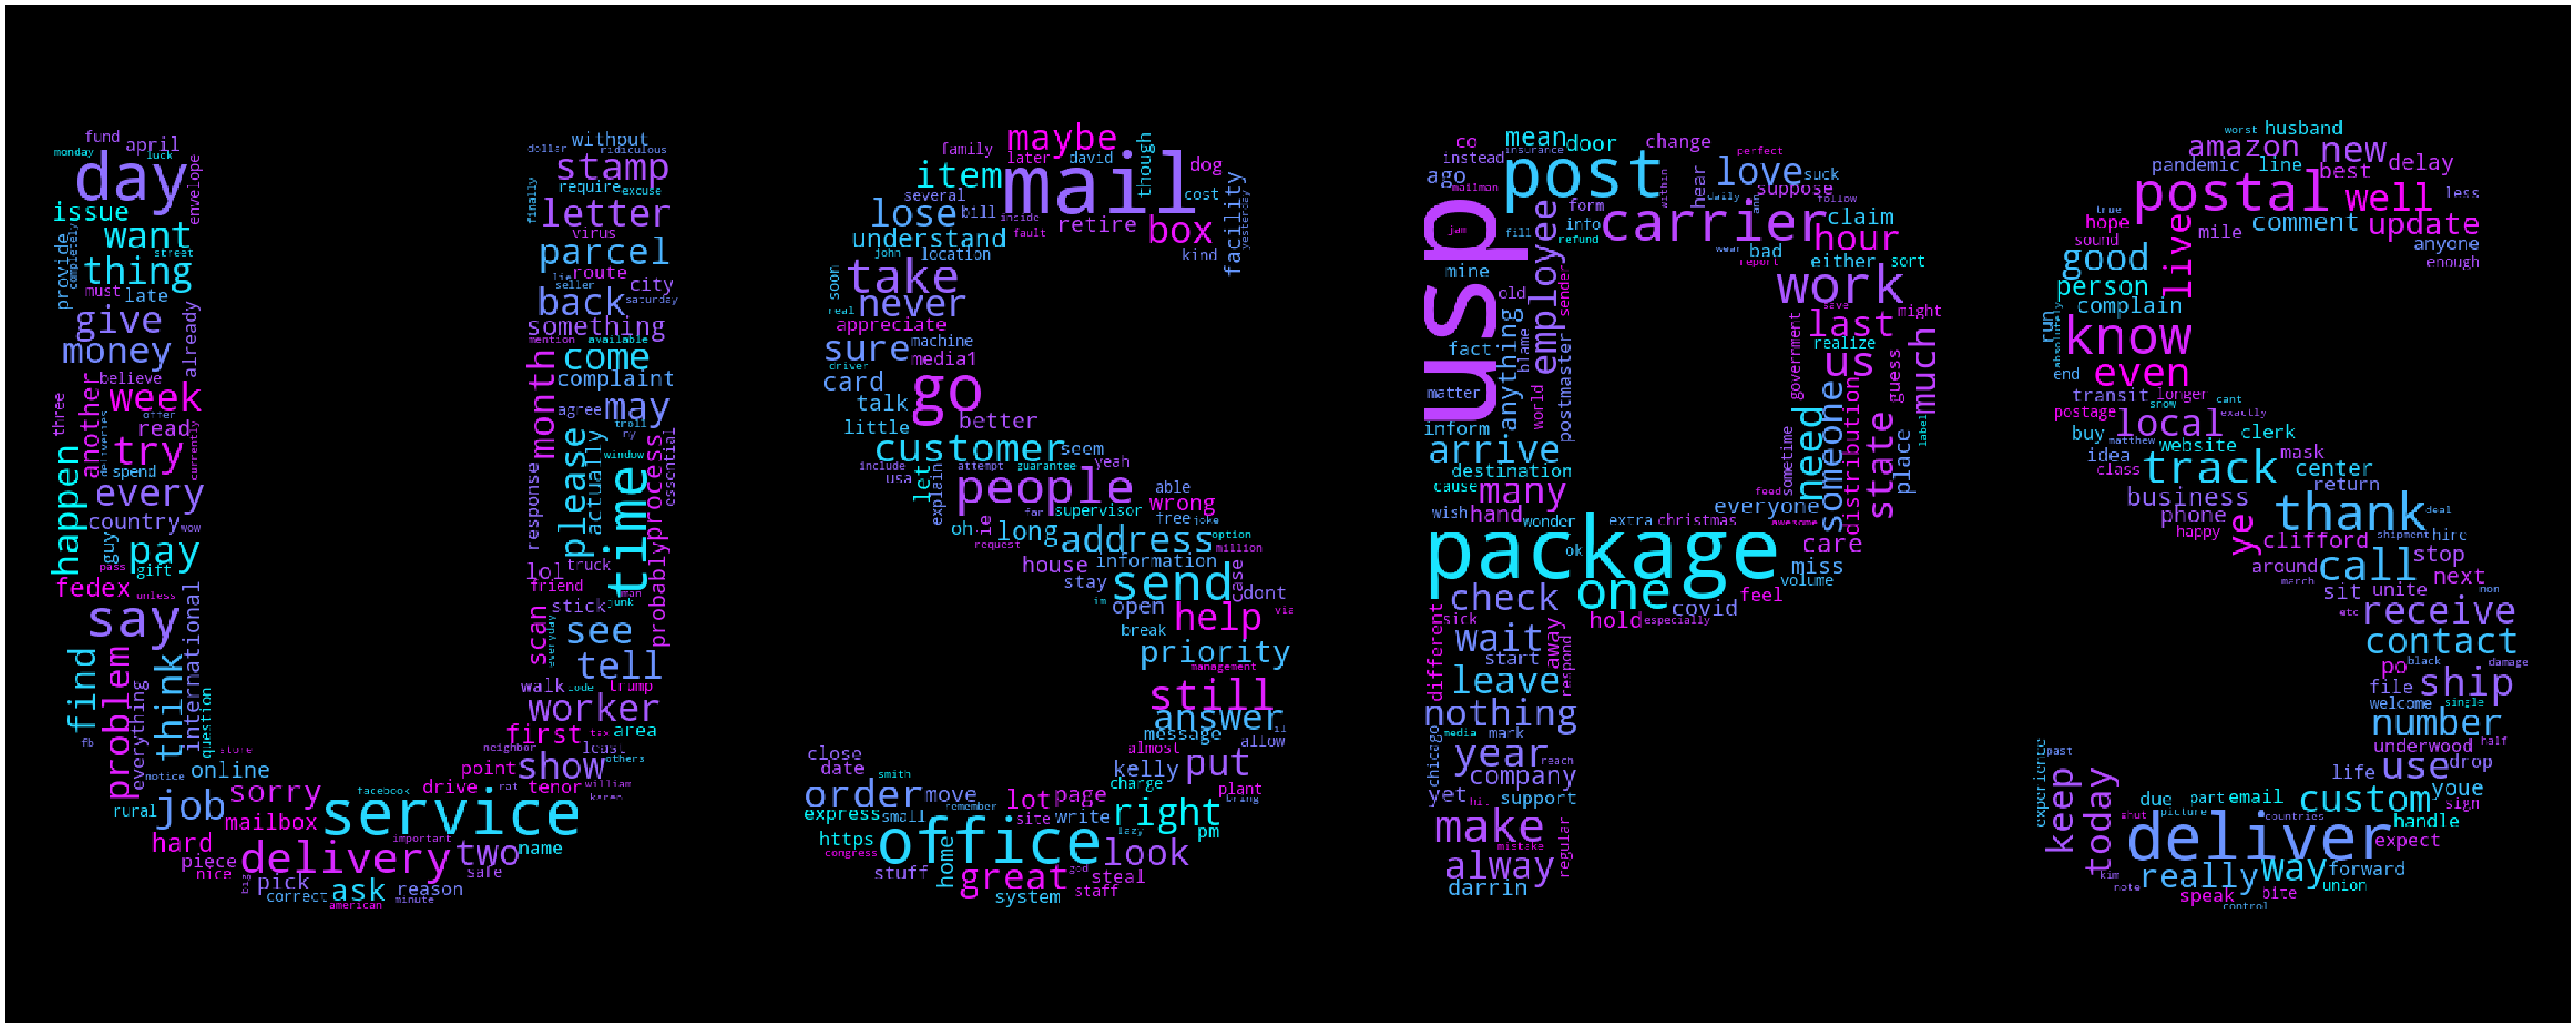

In [79]:
plot_word_cloud(df,'text_prep','pics/usps1.jpeg')

### Most Commen Words

In [80]:
name_lower = [] 
for i in set(name):
    name_lower.append(i.lower())

In [81]:
def plot_most_common_words(df, column, threshold, n):
    vec = CountVectorizer(ngram_range=(n,n), max_features=2000).fit(df[column])
    bag_of_words = vec.transform(df[column])
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in     
                  vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], 
                reverse=True)
    
    for i in words_freq:
        if i[0] in name_lower:
            words_freq.remove(i)
    
    x = [i[0] for i in words_freq[:threshold]]
    y = [i[1] for i in words_freq[:threshold]]
    
    most_common = pd.DataFrame({"word":x,"count":y})
    fig = px.bar(most_common, x="word", y='count',
                color='count', height=400)
    fig.update_layout(title_text=f'Most Common Words ({n}-grams)',title_x=0.5)
    fig.show()    

In [82]:
for i in [1,2]:
    plot_most_common_words(df,'text_prep',10,i)

### Most Active Replier 

In [83]:
threshold = 10

df_top_active = df.groupby("name").count().sort_values(by='text',ascending=False)[:threshold].reset_index()

fig = px.bar(df_top_active, x="name", y='text',
            color='text', height=400,
            labels={'text':'count','name':'replier'})
fig.update_layout(title_text='Most Active Replier',title_x=0.5)
fig.show()

### Time series plot

In [108]:
df_time_series = df[df.date.notnull()]

In [109]:
df_time_series.isnull().sum()

name                  0
text                  0
date                  0
like                  0
reply_to              0
day                   0
month                 0
dayofweek             0
text_prep             0
polarity              0
subjectivity          0
subjectivity_label    0
polarity_label        0
dtype: int64

In [110]:
df_time_series['month'] = df_time_series['month'].apply(lambda x: int(x))
df_time_series['day'] = df_time_series['day'].apply(lambda x: int(x))
df_time_series['dayofweek'] = df_time_series['dayofweek'].apply(lambda x: int(x))

In [122]:
df_time_series.drop(df_time_series.query("month == 12").index, inplace=True)

In [123]:
data_by_month = df_time_series.groupby("month").count().reset_index()

In [124]:
fig = px.bar(data_by_month, x="month", y="name", 
             color="name", text='name',
            labels={"month":"month","name":"cont"})
fig.update_traces(texttemplate='%{text:.2s}', textposition='outside')
fig.update_layout(uniformtext_minsize=8, uniformtext_mode='hide')
fig.update_layout(title_text='Total Comments (by month)', title_x=0.5)
fig.show()

In [131]:
data_by_dayofweek = df_time_series.groupby("dayofweek").count().reset_index()

fig = px.bar(data_by_dayofweek, x="dayofweek", y="name", 
             color="name", text='name',
            labels={"dayofweek":"dayofweek","name":"count"})
fig.update_traces(texttemplate='%{text:.2s}', textposition='outside')
fig.update_layout(uniformtext_minsize=8, uniformtext_mode='hide')
fig.update_layout(title_text='Total Comments (by day of week)', title_x=0.5)
fig.show()

In [128]:
data_by_date = df_time_series.groupby(["date"]).count().reset_index()

fig = px.line(data_by_date, x='date', y='name',
             labels={"name":"count"})
fig.update_xaxes(rangeslider_visible=True, rangeselector=dict(
        buttons=list([
            dict(count=1, label="1m", step="month", stepmode="backward"),
            dict(count=6, label="6m", step="month", stepmode="backward"),
            dict(count=1, label="YTD", step="year", stepmode="todate"),
            dict(count=1, label="1y", step="year", stepmode="backward"),
            dict(step="all")
        ])
    ))
fig.update_layout(uniformtext_minsize=8, uniformtext_mode='hide')
fig.update_layout(title_text='Total Comments (by date)', title_x=0.5)
fig.show()

### Polarization 

#### Sentiment Classification 

In [132]:
df['polarity'] = df['text_prep'].parallel_apply(lambda x: round(TextBlob(x).polarity,3))

In [133]:
df['subjectivity'] = df['text_prep'].parallel_apply(lambda x: round(TextBlob(x).subjectivity,3))

In [134]:
df.polarity.describe()

count    9661.000000
mean        0.060890
std         0.274838
min        -1.000000
25%         0.000000
50%         0.000000
75%         0.158000
max         1.000000
Name: polarity, dtype: float64

In [135]:
df.subjectivity.describe()

count    9661.000000
mean        0.330677
std         0.317406
min         0.000000
25%         0.000000
50%         0.320000
75%         0.567000
max         1.000000
Name: subjectivity, dtype: float64

In [136]:
# labeling subjectivity
def subjectivity_labeling(df,threshold=0.5):
    if threshold == 0.5:
        df.loc[df.subjectivity > 0.5,"subjectivity_label"] = 'subjective'
        df.loc[df.subjectivity < 0.5,"subjectivity_label"] = 'objective'
        df.loc[df.subjectivity == 0.5,"subjectivity_label"] = 'natural'
    else:
        df.loc[df.subjectivity >= threshold,"subjectivity_label"] = 'subjective'
        df.loc[df.subjectivity <= (1-threshold),"subjectivity_label"] = 'objective'
        df.loc[df.subjectivity < 0.5 and df.subjectivity > (1-threshold),"subjectivity_label"] = 'natural'
        
    return df

def polarity_labeling(df,threshold=0):
    if threshold == 0:
        df.loc[df.polarity > 0,"polarity_label"] = 'positive'
        df.loc[df.polarity < 0,"polarity_label"] = 'negative'
        df.loc[df.polarity == 0,"polarity_label"] = 'natural'
    else:
        df.loc[df.polarity >= threshold,"polarity_label"] = 'positive'
        df.loc[df.polarity <= (-threshold),"polarity_label"] = 'negative'
        df.loc[df.polarity < 0 and df.subjectivity > (-threshold),"polarity_label_label"] = 'natural'
        
    return df

In [137]:
df = subjectivity_labeling(df)
df = polarity_labeling(df)

In [138]:
df.sample(3)

name  \
6234          Julia Singer   
3792         Linda Ivester   
325   Debbie Miles Toenyes   

                                                                                                                                                                                                                                                                                                                                 text  \
6234                                                                                                                                                                                                                                                Wendy Sengstock that is crazy. I wonder too where is my grandson's birthday box.    
3792                                                                                                                                     Jennifer Stewart what do you mean by \hiding g\...they are out in the public 7 days a week...just cause they are practicing social distancing as they should be doesnt mean they are hiding    
325   Patricia Gardner Smith I a retired rural mail carrier. Driving on icy rural roads with hite outs  and flooded roads chased by dogs roosters geese ... driving with a flashlight to read addresses on my mail and houses..freezing vehicles in the winter cooking vehicles in the summer..no one understands unless they do it.    

           date like                reply_to   day  month  dayofweek  \
6234 2020-04-16    0         Wendy Sengstock  16.0    4.0        3.0   
3792 2020-06-10    1        Jennifer Stewart  10.0    6.0        2.0   
325  2020-03-06    1  Patricia Gardner Smith   6.0    3.0        4.0   

                                                                                                                                                                                                                            text_prep  \
6234                                                                                                                                                                               wendy sengstock crazy wonder grandson birthday box   
3792                                                                                                                                  jennifer stewart mean hide g public 7 days week cause practice social distance doesnt mean hide   
325   patricia gardner smith retire rural mail carrier drive icy rural roads hite out flood roads chase dog roosters geese drive flashlight read address mail house freeze vehicles winter cook vehicles summer one understand unless   

      polarity  subjectivity subjectivity_label polarity_label  
6234    -0.600         0.900         subjective       negative  
3792    -0.148         0.377          objective       negative  
325     -0.033         0.033          objective       negative

In [139]:
# save the dataset with sentiment if needed
if False:
    df.to_csv("preprocessed_dataset/Facebook_preprocessed_USPS.csv")

#### Sentiment Overview

In [140]:
fig =px.sunburst(
    df.groupby(["polarity_label",'subjectivity_label']).count().name.reset_index(),
    path=['polarity_label', 'subjectivity_label'],
    values='name',color='name',
    color_continuous_scale='RdBu')
fig.update_layout(title_text='Sentiment Distribution', title_x=0.5)
fig.show()

In [141]:
def plot_people_sentiment(df, polarity_threshold=0,subjectivity_thresould=0.5):
    df = df[(df.polarity > polarity_threshold) | (df.polarity < (-polarity_threshold))]
    df = df[(df.subjectivity > subjectivity_thresould) | (df.subjectivity < (1-subjectivity_thresould))]
    df.like = df.like.apply(lambda x: round(int(x),2))
    fig = px.scatter(df.reset_index(), hover_name="name",
                 x="polarity", y="subjectivity", size="like", color="polarity",
                 log_x=False, size_max=60, labels={'text':'count','name':'replier'})
    fig.update_layout(title_text='Sentiment Overview',title_x=0.5)
    fig.show()
    
plot_people_sentiment(df)

In [142]:
def plot_subjectivity(df, subjectivity_threshold = 0.5, log_y=False):
    df = df[(df.subjectivity > subjectivity_threshold) | (df.subjectivity < (1-subjectivity_threshold))]
    fig = px.histogram(df, x="subjectivity", marginal="box",
                      opacity=0.8, log_y=log_y,
                      color_discrete_sequence=['indianred'])
    fig.update_layout(title_text='Subjectivity Distribution',title_x=0.5)
    fig.show()

plot_subjectivity(df,log_y=True)    

In [143]:
def plot_polarity(df, polarity_threshold = 0):
    df = df[(df.polarity > polarity_threshold) | (df.polarity < (-polarity_threshold))]
    fig = px.histogram(df, x="polarity", marginal="box",
                      opacity=0.8)
    fig.update_layout(title_text='Polarity Distribution',title_x=0.5)
    fig.show()

plot_polarity(df,0)    

#### Positive/Negative Comments Word Cloud

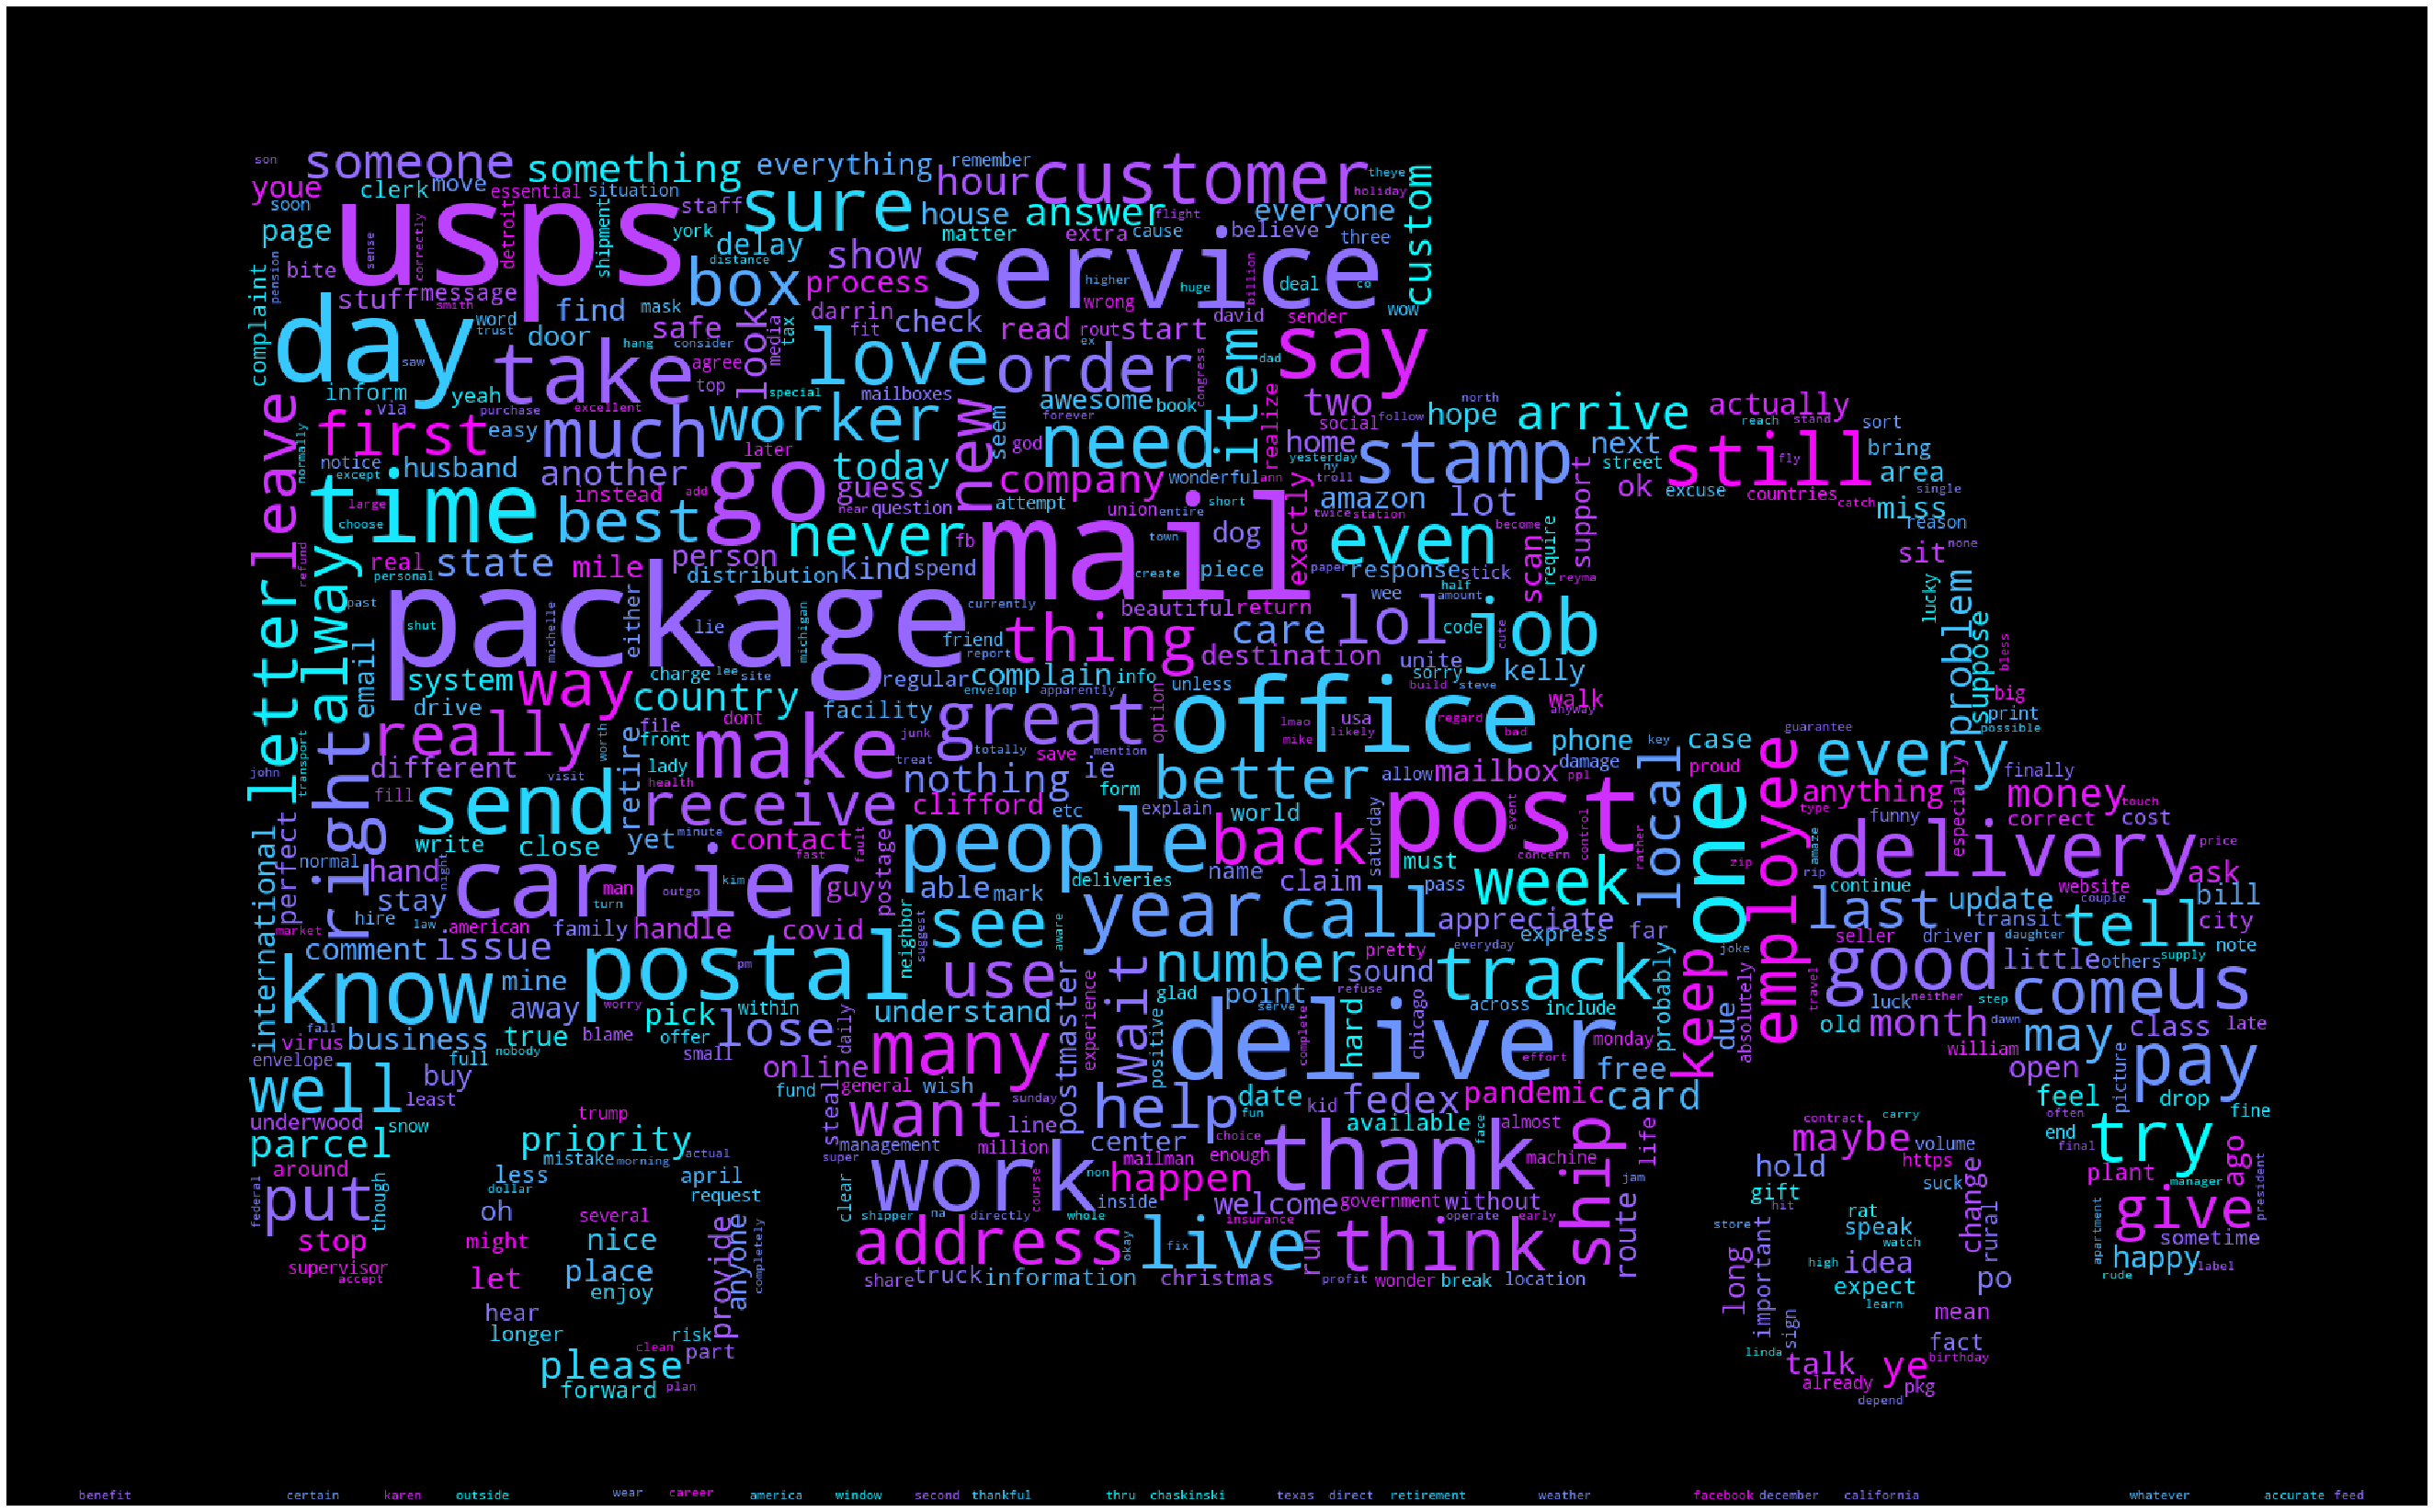

In [44]:
plot_word_cloud(df.query("polarity_label == 'positive'"),'text_prep','pics/truck.jpeg')

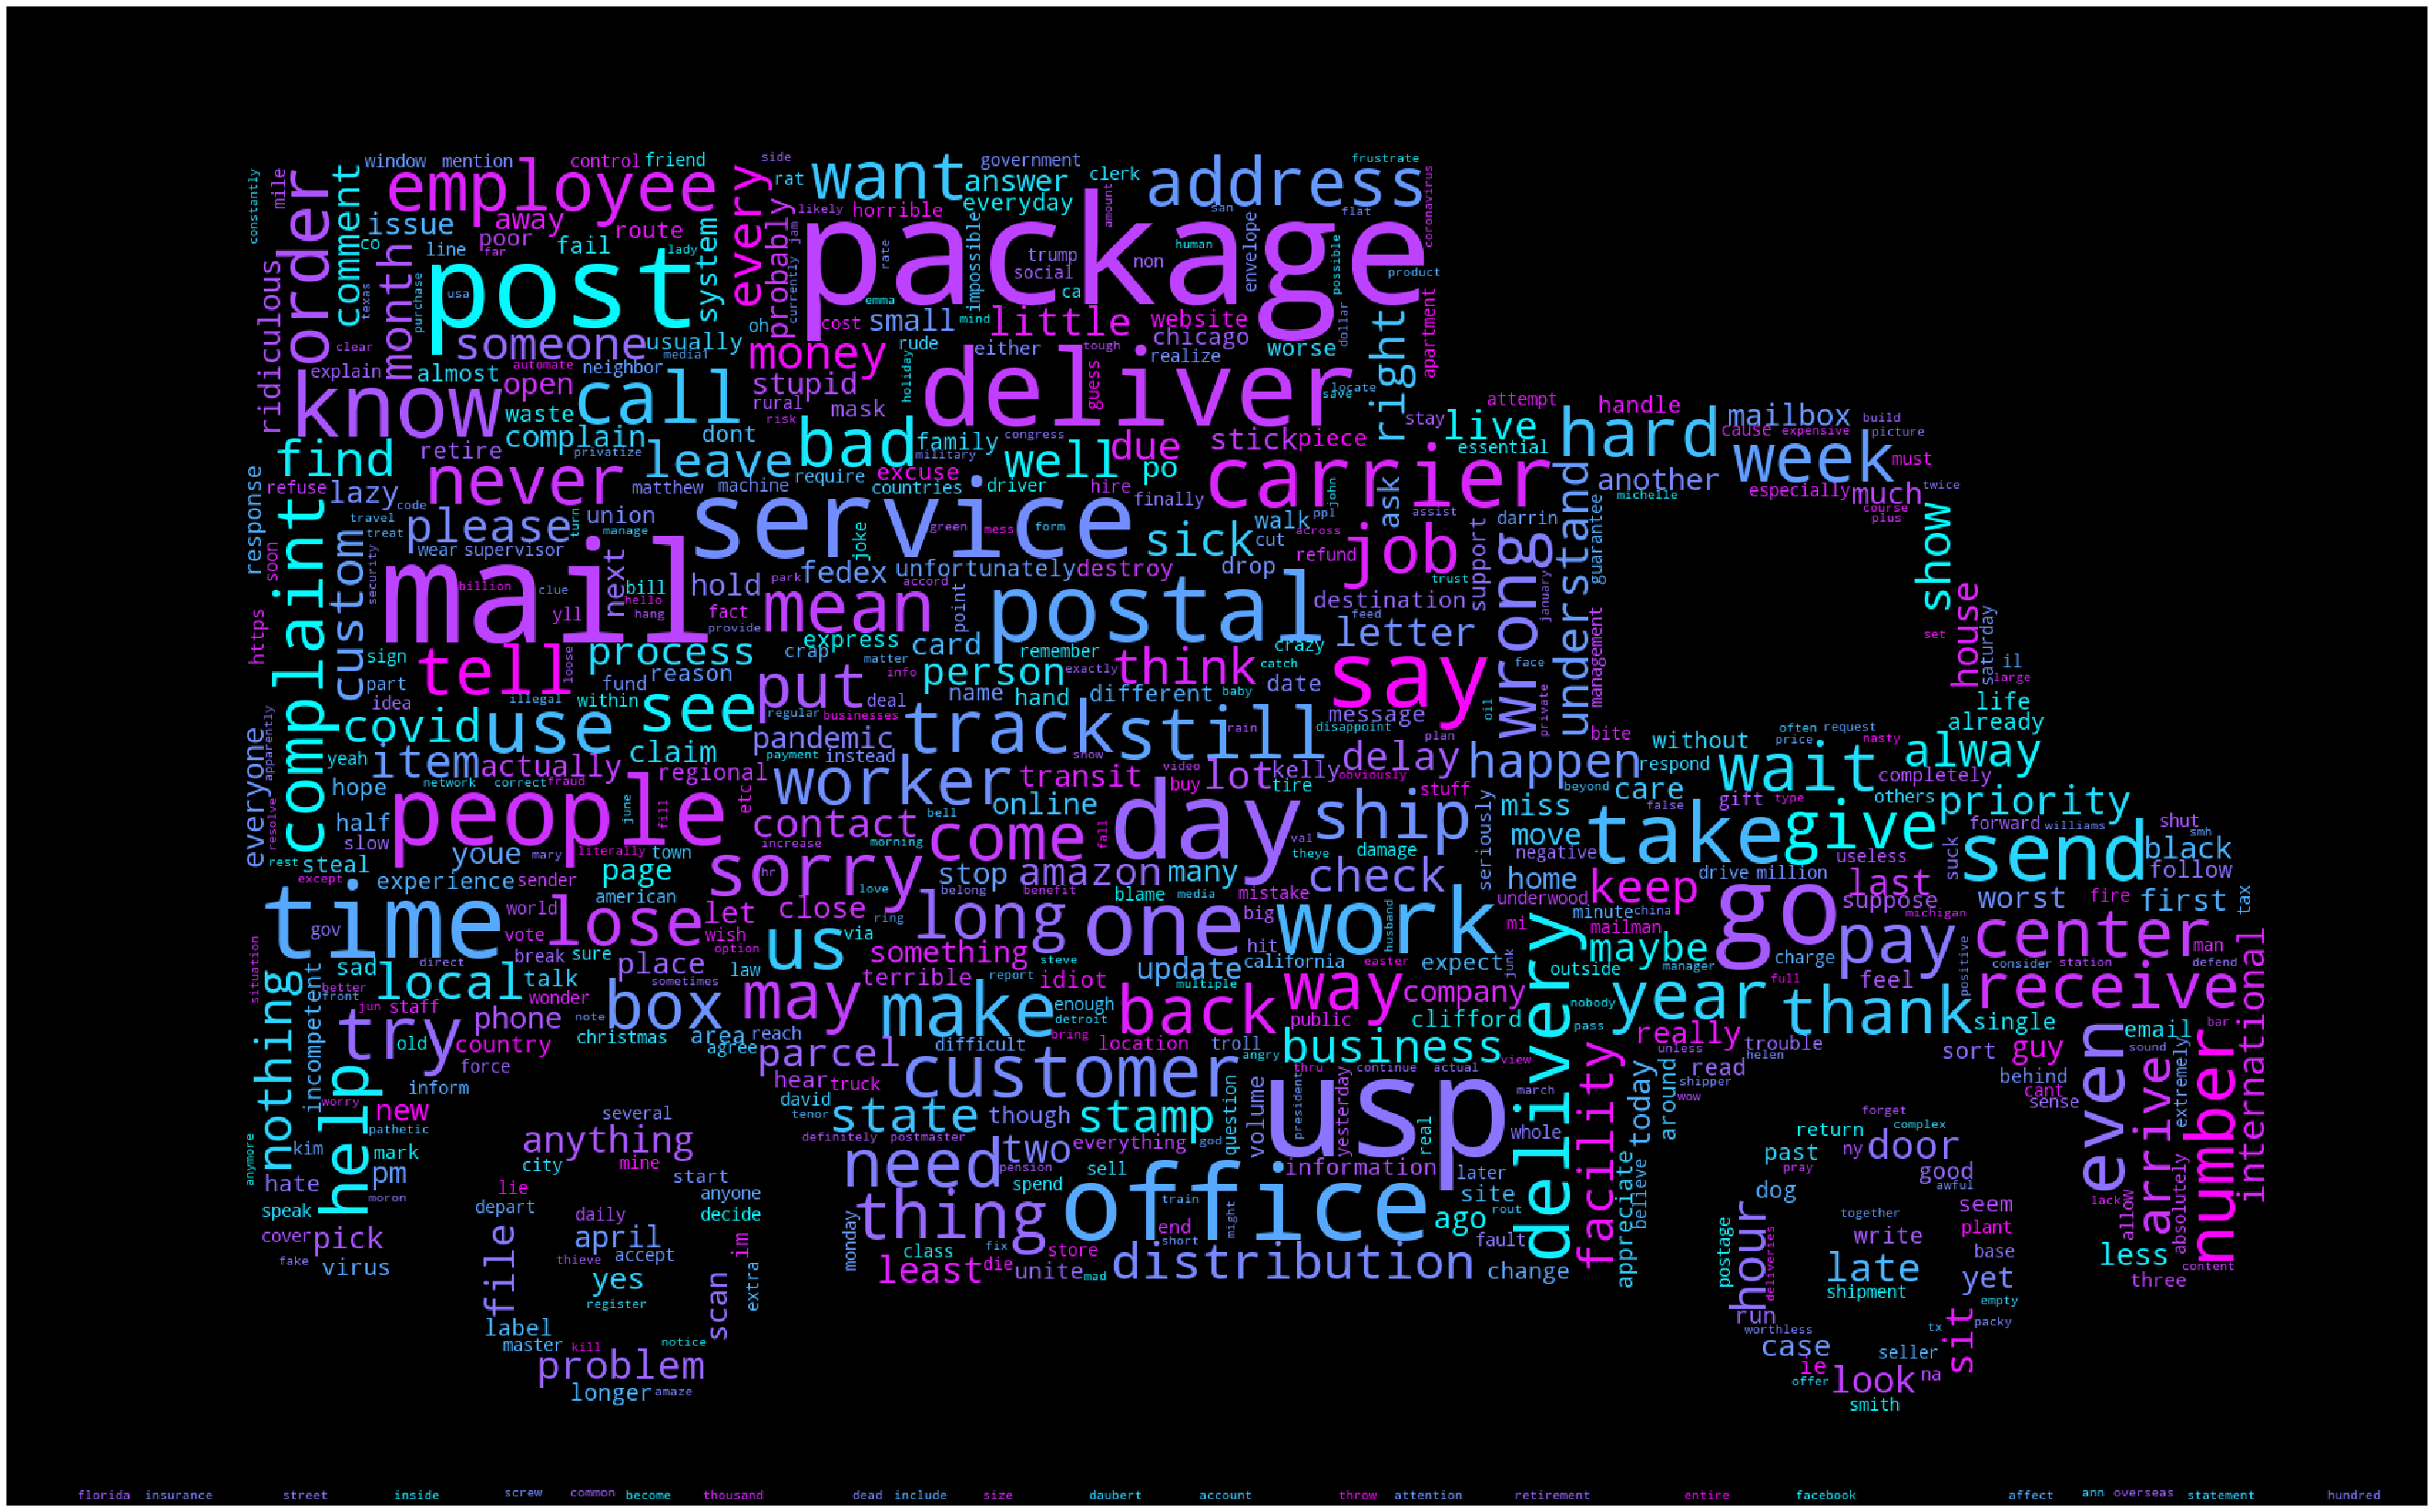

In [45]:
plot_word_cloud(df.query("polarity_label == 'negative'"),'text_prep','pics/truck.jpeg')

#### Positive/Negative Most Common Words

In [144]:
def plot_senti_most_common_words(dataset, column, sentiment, 
                                 threshold=0, topwords=10, n=1):

    if sentiment == 'positive':
        df = dataset.query(f"polarity_label == '{sentiment}' and polarity >= {threshold}")
    if sentiment == 'negative':
        df = dataset.query(f"polarity_label == '{sentiment}' and polarity <= (-{threshold})")   
        
    vec = CountVectorizer(ngram_range=(n,n), max_features=2000).fit(df[column])
    bag_of_words = vec.transform(df[column])
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in     
                  vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], 
                reverse=True)
    
    for i in words_freq:
        if i[0] in name_lower:
            words_freq.remove(i)
    
    x = [i[0] for i in words_freq[:topwords]]
    y = [i[1] for i in words_freq[:topwords]]
    
    most_common = pd.DataFrame({"word":x,"count":y})
    fig = px.bar(most_common, x="word", y='count',
                color='count', height=400)
    fig.update_layout(title_text=f'Most Common Words ({sentiment},{n}-grams)',title_x=0.5)
    fig.show() 

In [145]:
plot_senti_most_common_words(df, 'text_prep','negative',0.2,n=2)

In [146]:
plot_senti_most_common_words(df,'text_prep','positive',0.2,n=2)

#### Positive/Negative Most Active Replier

In [147]:
def most_active_plot(dataset,threshold=10,sentiment='positive'):
    df_senti_active_replier = dataset.query(f"polarity_label == '{sentiment}'").groupby("name").count().sort_values(by='text',ascending=False)[:threshold].reset_index()

    fig = px.bar(df_senti_active_replier, x="name", y='text',
                color='text', height=400,
                labels={'text':'count','name':'replier'})
    fig.update_layout(title_text=f'Most Active Replier ({sentiment})',title_x=0.5)
    fig.show()
    
most_active_plot(df)

In [148]:
most_active_plot(df, sentiment='negative')

#### Time series plot based on polarization/subjectivity

In [165]:
fig = px.histogram(df.loc[df.query("month != 12").index], x="date",
                   color='polarity_label',
                   marginal="rug",
                   opacity=0.8)
fig.show()

In [164]:
fig = px.histogram(df.loc[df.query("month != 12").index], x="date",
                   color='subjectivity_label',
                   marginal="rug",
                   opacity=0.8)
fig.show()

### Social Network Visualization

In [51]:
# create name pair
name_pair = []

for i in tqdm_notebook(range(len(df))):
    if len(df.loc[i,'reply_to']) > 0:
        name_pair.append([df.loc[i,'name'],df.loc[i,'reply_to']])

In [52]:
df_network = pd.DataFrame(name_pair)
df_network.columns = ['replier','reply_to']
df_network.head(10)

replier              reply_to
0          Robert Nance        Crystal Fickel
1  Becky Campbell Watts  Kelly Curry-Sugarman
2         Bonnie Bowers  Kelly Curry-Sugarman
3         Matthew Black  Kelly Curry-Sugarman
4         Matthew Black        Crystal Fickel
5           Blane Harry           Jay Richard
6     Connie Cunningham           Blane Harry
7            Sandy Crow     Cherie Seigneurie
8           Ellen Mazer     Cherie Seigneurie
9         Sally Knights             Den Goose

In [55]:
df_network.to_csv("output/graph_dataframe_USPS.csv")

In [56]:
G = nx.Graph()
G.add_nodes_from(df_network.replier)
G.add_nodes_from(df_network.reply_to)
G.add_edges_from(df_network.values)
print(nx.info(G))

Name: 
Type: Graph
Number of nodes: 2626
Number of edges: 3441
Average degree:   2.6207


/Users/hkmac/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning:


The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.



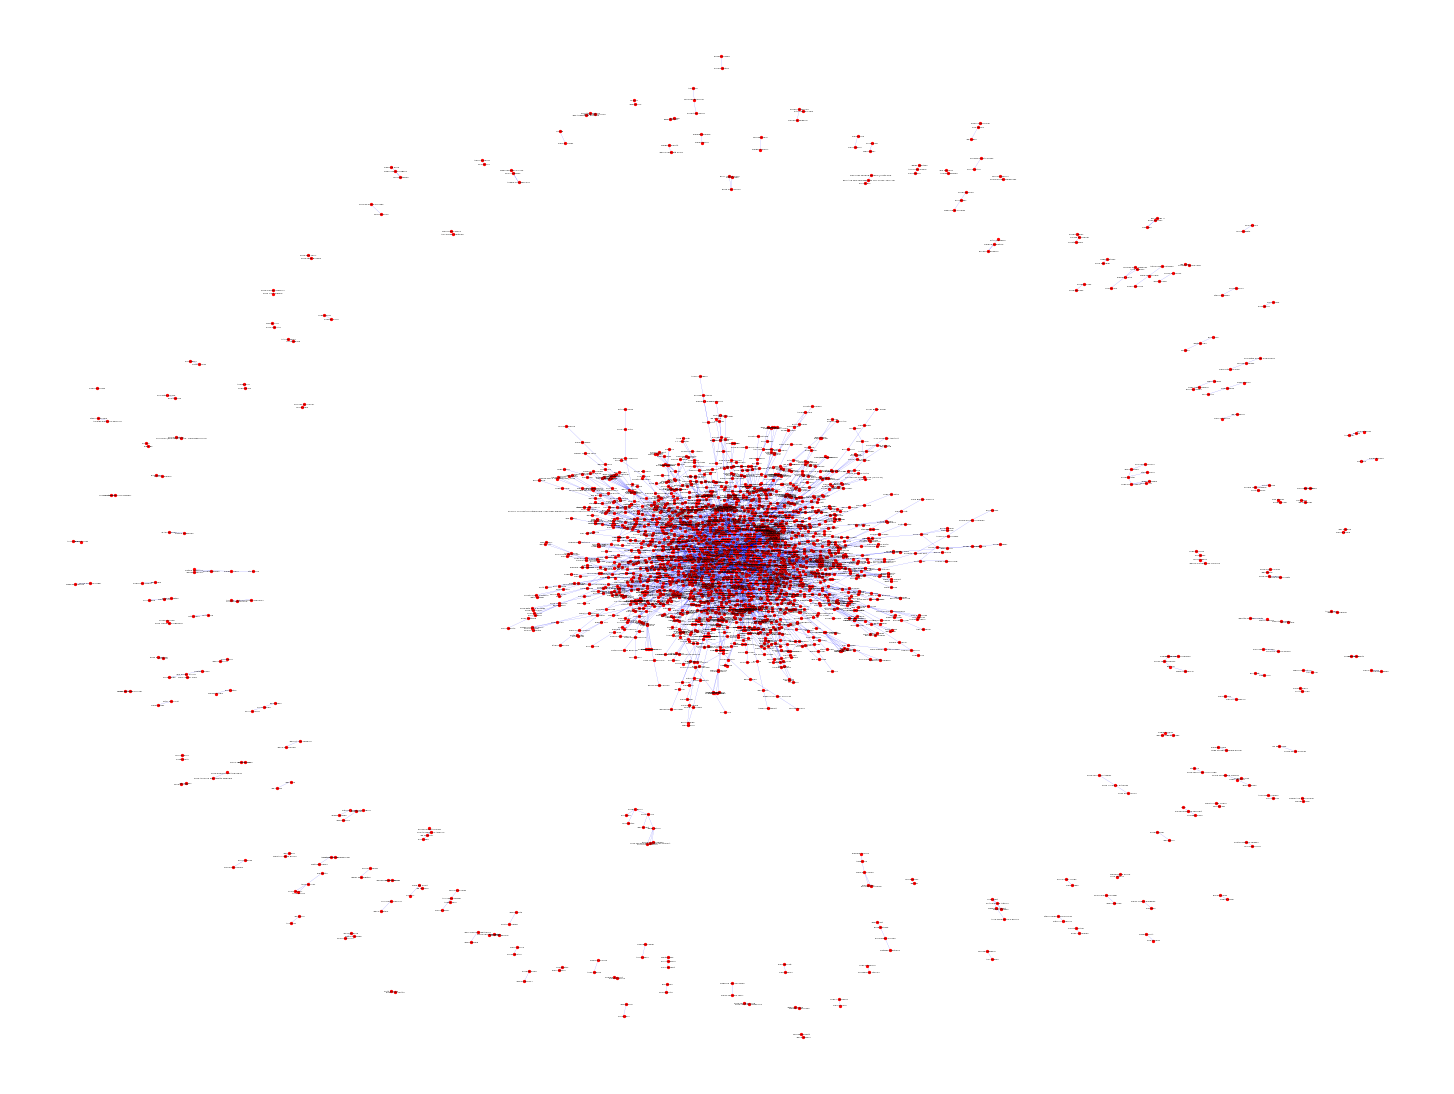

In [59]:
plt.figure(figsize=(20,15))
pos = nx.spring_layout(G)
nx.draw(G,pos,with_labels=True, node_color='r', edge_color='b', node_size=5,
        width=0.1,font_size=2, font_family='sans-serif') 
plt.axis('off')
plt.show()

### Word2Vec Visualization

In [57]:
def build_corpus(df):
    corpus = []
    for sentence in df['text_prep']:
        word_list = sentence.split(" ")
        corpus.append(word_list)
            
    return corpus

corpus = build_corpus(df)  
model = word2vec.Word2Vec(corpus, size=200, window=100, min_count=30, workers=4)

In [58]:
def tsne_plot(model):
    labels = []
    tokens = []

    for word in model.wv.vocab:
        tokens.append(model[word])
        labels.append(word)
    
    tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)
    new_values = tsne_model.fit_transform(tokens)

    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])
        
    plt.figure(figsize=(15, 10)) 
    for i in range(len(x)):
        plt.scatter(x[i],y[i])
        plt.annotate(labels[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    plt.show()

/Users/hkmac/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).



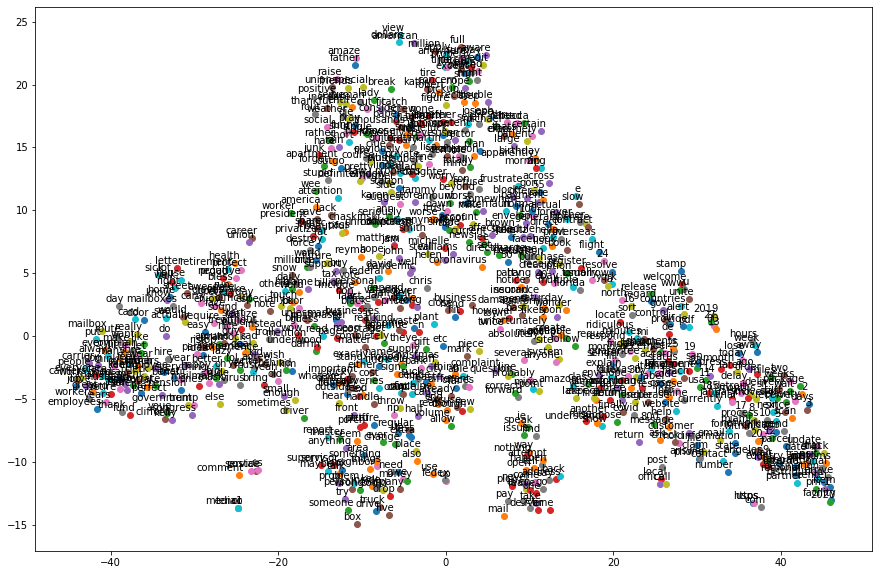

In [486]:
tsne_plot(model)

## Vectorization

In [478]:
topwords = [word for word, _ in voca.most_common(10000)]

In [479]:
tf_vec = TfidfVectorizer(vocabulary=topwords)
tf_vec

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=1.0, max_features=None,
                min_df=1, ngram_range=(1, 1), norm='l2', preprocessor=None,
                smooth_idf=True, stop_words=None, strip_accents=None,
                sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, use_idf=True,
                vocabulary=['usps', 'package', 'mail', 'post', 'deliver',
                            'service', 'office', 'postal', 'work', 'thank',
                            'send', 'people', 'take', 'like', 'track', 'make',
                            'days', 'delivery', 'carrier', 'us', 'call',
                            'still', 'job', 'need', 'try', 'even', 'pay',
                            'order', 'ship', 'stamp', ...])

In [480]:
features = tf_vec.fit_transform(df['text_prep'])

In [481]:
features.toarray()

array([[0.        , 0.32192596, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.27056537, ..., 0.        , 0.        ,
        0.        ],
       [0.13769292, 0.07080024, 0.07256242, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.10945693, 0.22436251, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.08473116, 0.08713573, 0.        , ..., 0.        , 0.        ,
        0.        ]])